### Face Recognition


Downloading dataset

In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from tf_keras.utils import to_categorical

# Download the full LFW dataset with all people included (no filtering)
lfw_people=fetch_lfw_people(min_faces_per_person=0,resize=0.4,color=False)

# Get the face images and labels
data=lfw_people.images # face images
labels=lfw_people.target # people
target_names= lfw_people.target_names #list of all person names





KeyboardInterrupt: 

In [ ]:
#Print dataset details
print(f"Total images: {data.shape[0]}")
print(f"Image size : {data.shape[1]}x{data.shape[2]}") # heightxwidth
print(f"Number of classes (people) : {len(target_names)}")

Total images: 13233
Image size : 50x37
Number of classes (people) : 5749


In [ ]:
#Reshape the data to include the channel dimension (for grayscale images, channel 1)
data = data.reshape((data.shape[0], data.shape[1],data.shape[2],1))
#split tha data
x_train,x_test, y_train,y_test= train_test_split(data,labels,test_size=0.2,random_state=42)

print(f"Training data shape : {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")

Training data shape : (10586, 50, 37, 1)
Testing data shape: (2647, 50, 37, 1)


### Create the EfficientNetB0 Model

In [ ]:

import tf_keras as tf
from tf_keras import layers, Model

def mb_conv_block(x,inputs,filters,kernel_size,strides,expand_ratio,se_ratio):
    in_channels=x.shape[-1] # Number of inputs filters
    expanded_filter=in_channels * expand_ratio
    
    #Expension phase
    if expand_ratio != 1:
        x =layers.Conv2D(expanded_filter,kernel_size=1, padding='same',use_bias=False)(x)
        x=layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
    else:
        x=x
        
    #Depthwise convolution
    x=layers.DepthwiseConv2D(kernel_size,strides=strides,padding='same',use_bias=False)(x)
    x=layers.BatchNormalization()(x)
    x=layers.ReLU()(x)
    
    # Squeeze and Excitation block
    # if se_ratio:
    #     se_shape=(1,1,in_channels * expand_ratio)
    #     se=layers.GlobalAveragePooling2D()(x)
    #     se=layers.Reshape(se_shape)(x)
    #     se=layers.Dense(se_shape[-1]//4,activation='relu')(se)
    #     se=layers.Dense(se_shape[-1],activation='sigmoid')(se)
    #     x=layers.multiply([x,se])
    
    
    if se_ratio:
        in_channels = x.shape[-1]
        se_shape = (1, 1, in_channels)
        se = layers.GlobalAveragePooling2D()(x)  # This should output shape (None, in_channels)
        se = layers.Reshape(se_shape)(se)  # Change this line to match the output shape
        se = layers.Dense(in_channels // 4, activation='relu')(se)
        se = layers.Dense(in_channels, activation='sigmoid')(se)
        x = layers.multiply([x, se])  # Apply the squeeze-and-excitation weights

        
    #Output phase
    x=layers.Conv2D(filters,kernel_size=1,padding='same',use_bias=False)(x)
    x= layers.BatchNormalization()(x)
    
    if in_channels ==filters and strides ==1:
        x=layers.add([x,inputs])
        
    return x          
    



### Creating Model

In [ ]:
def EfficientNetB0(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Initial Conv layer
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # MBConv Blocks
    # x = mb_conv_block(x, filters=16, kernel_size=3, strides=1, expand_ratio=1, se_ratio=0,)
    # x = mb_conv_block(x, filters=24, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)
    # x = mb_conv_block(x, filters=24, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    # x = mb_conv_block(x, filters=40, kernel_size=5, strides=2, expand_ratio=6, se_ratio=0.25)
    # x = mb_conv_block(x, filters=40, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    # x = mb_conv_block(x, filters=80, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0)
    # x = mb_conv_block(x, filters=80, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0)
    # x = mb_conv_block(x, filters=80, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0)
    # x = mb_conv_block(x, filters=112, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    # x = mb_conv_block(x, filters=112, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    # x = mb_conv_block(x, filters=192, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)
    # x = mb_conv_block(x, filters=192, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    
    x = mb_conv_block(x,inputs=x, filters=16, kernel_size=3, strides=1, expand_ratio=1, se_ratio=0)
    x = mb_conv_block(x,inputs=x, filters=24, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x,inputs=x, filters=24, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x,inputs=x, filters=40, kernel_size=5, strides=2, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x,inputs=x, filters=40, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x,inputs=x, filters=80, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0)
    x = mb_conv_block(x,inputs=x, filters=80, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0)
    x = mb_conv_block(x,inputs=x, filters=80, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0)
    x = mb_conv_block(x,inputs=x, filters=112, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x,inputs=x, filters=112, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x,inputs=x, filters=192, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x,inputs=x, filters=192, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1280, activation='relu')(x)  # Call the Dense layer with x as input
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)    
    return model


In [ ]:
# Instantiate the model (creating an instance of a model)
model = EfficientNetB0(input_shape=(x_train.shape[1], x_train.shape[2], 1), num_classes=len(target_names))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Train the model
history= model.fit(x_train,y_train,epochs=10, batch_size=32,validation_data=(x_test, y_test))


Epoch 1/10
  2/331 [..............................] - ETA: 20s - loss: 8.6646 - accuracy: 0.0000e+00 

KeyboardInterrupt: 

In [ ]:
#Evaluate the model on the test set
test_loss , test_acc = model.evaluate(x_test,y_test)
print(f"Test accuracy : {test_acc * 100:.2f}%")

83/83 [==============================] - 1s 12ms/step - loss: 13.7448 - accuracy: 0.0604
Test accuracy : 6.04%


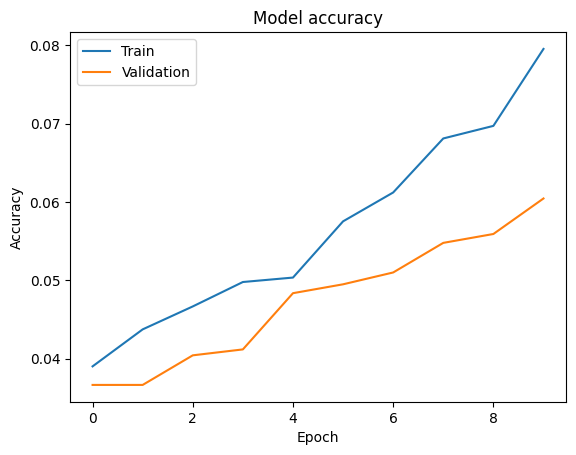

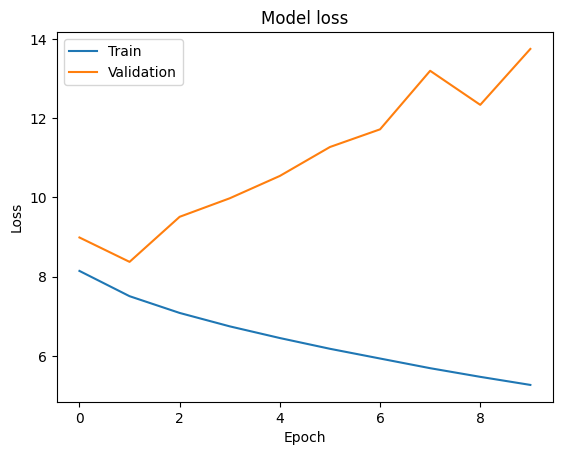

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# data agumentation
import numpy as np
from tf_keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,         # Scale pixel values to [0, 1]
    rotation_range=20,           # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,       # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,      # Randomly shift images vertically (fraction of total height)
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Randomly zoom into images
    horizontal_flip=True,         # Randomly flip images
    fill_mode='nearest',          # Fill in new pixels after rotation or width/height shifts
    )

In [ ]:
# Create a generator for the training data
train_generator = train_datagen.flow(x_train, y_train, batch_size=32)

In [ ]:
from tf_keras.models import clone_model
model_2=tf.models.clone_model(model)

In [ ]:
model_2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_2= model_2.fit(train_generator,steps_per_epoch=len(x_train)//32, epochs=5,validation_data=(x_test,y_test))

Epoch 1/5
330/330 [==============================] - 19s 55ms/step - loss: 8.1879 - accuracy: 0.0401 - val_loss: 9.7375 - val_accuracy: 0.0366
Epoch 2/5
330/330 [==============================] - 19s 57ms/step - loss: 7.7897 - accuracy: 0.0407 - val_loss: 946.2828 - val_accuracy: 0.0366
Epoch 3/5
330/330 [==============================] - 20s 60ms/step - loss: 7.5791 - accuracy: 0.0415 - val_loss: 12414.0781 - val_accuracy: 0.0302
Epoch 4/5
330/330 [==============================] - 19s 59ms/step - loss: 7.4150 - accuracy: 0.0421 - val_loss: 15965.6504 - val_accuracy: 0.0366
Epoch 5/5
330/330 [==============================] - 19s 58ms/step - loss: 7.2665 - accuracy: 0.0411 - val_loss: 6899.3965 - val_accuracy: 7.5557e-04


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

83/83 [==============================] - 1s 11ms/step - loss: 13.7448 - accuracy: 0.0604
Test accuracy: 6.04%


### EfficientNetB7

In [ ]:
# import tensorflow as tf

# # Resize images to (600, 600) and convert to 3 channels
# x_train_resized = tf.image.resize(x_train, (600, 600))
# x_train_resized = tf.image.grayscale_to_rgb(x_train_resized)

# x_test_resized = tf.image.resize(x_test, (600, 600))
# x_test_resized = tf.image.grayscale_to_rgb(x_test_resized)


In [ ]:
def EfficientNetB7(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Initial Conv layer
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # MBConv Blocks following EfficientNetB7 architecture scaling
    x = mb_conv_block(x, inputs=x, filters=32, kernel_size=3, strides=1, expand_ratio=1, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=32, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=48, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=48, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=80, kernel_size=5, strides=2, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=80, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=160, kernel_size=5, strides=2, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=160, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=224, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=224, kernel_size=5, strides=1, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=384, kernel_size=3, strides=2, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=384, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    x = mb_conv_block(x, inputs=x, filters=640, kernel_size=3, strides=1, expand_ratio=6, se_ratio=0.25)
    
    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Adding dropout for EfficientNetB7
    x = layers.Dense(2560, activation='relu')(x)  # Increased units as per EfficientNetB7
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model_3= Model(inputs, outputs)
    return model_3


In [ ]:
# model_3 = EfficientNetB7(input_shape=(600, 600, 3), num_classes=len(target_names))


In [ ]:
input_shape = (50, 37, 1)  # Set input shape to match the data
model_3 = EfficientNetB0(input_shape=input_shape, num_classes=len(target_names)) #B0

In [ ]:
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# Train the model with the resized data
history_3 = model_3.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/5
331/331 [==============================] - 19s 53ms/step - loss: 8.1712 - accuracy: 0.0396 - val_loss: 8.3839 - val_accuracy: 0.0366
Epoch 2/5
331/331 [==============================] - 17s 52ms/step - loss: 7.6364 - accuracy: 0.0412 - val_loss: 8.4861 - val_accuracy: 0.0374
Epoch 3/5
331/331 [==============================] - 17s 52ms/step - loss: 7.2959 - accuracy: 0.0426 - val_loss: 9.7747 - val_accuracy: 0.0404
Epoch 4/5
331/331 [==============================] - 17s 52ms/step - loss: 6.9563 - accuracy: 0.0457 - val_loss: 9.7090 - val_accuracy: 0.0442
Epoch 5/5
331/331 [==============================] - 17s 52ms/step - loss: 6.6128 - accuracy: 0.0482 - val_loss: 12.2089 - val_accuracy: 0.0427


In [ ]:
test_loss, test_acc = model_3.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

83/83 [==============================] - 1s 11ms/step - loss: 12.2089 - accuracy: 0.0427
Test accuracy: 4.27%


In [ ]:
# Save the model to a file
model_3.save('face_recognition_model.h5')


/Users/badalkr.sharma/Library/Python/3.9/lib/python/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tf_keras.models import load_model

# Load the model
model = load_model('face_recognition_model.h5')
